# Project: Transfer Learning - Letters to Numbers

###Brief Project Description
In this project, we aim to apply the concept of transfer learning using a CNN classification model designed for classifying images from the EMNIST dataset (achieving an accuracy above 90%). We reuse this model to classify images from the MNIST dataset, breaking down the approach into four steps.


*   **Step 1**: We first assess the performance of the source model on the FMNIST dataset.
*   **Step 2**: Next, we apply the unchanged source model to the MNIST dataset and evaluate the results.
*   **Step 3**: Then, we modify the output layer of our source model from 26 to 10 units, where 26 represents the number of different labels in the EMNIST dataset, and 10 is the number of labels in the MNIST dataset. We evaluate the performance of this modified source model.
* **Step 4**: In the final step, we create an untrained new model instance of the modified source model, referred to as the target model. We assign the weights of the trained but unchanged source model to the target model. Moreover, we subject it to a special kind of training, where we freeze the weights of all layers except the output layer. Subsequently, we assess the performance of the target model.






In [ ]:
# import libraries
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect the data

In [ ]:
# download the EMNIST dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# download the EMNIST dataset
ddata = torchvision.datasets.MNIST(root='mnist', download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [ ]:
# inspect the EMNIST data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
imagesEMNIST = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(imagesEMNIST.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [ ]:
# inspect the MNIST data

# the categories (but how many letters??)
print(ddata.classes)

print('\nTarget labels')
print(torch.unique(ddata.targets))
print(ddata.targets.shape)
labelsMNIST = ddata.targets

print('\nData size')
print(ddata.data.shape)


# transform to 4D tensor for conv layers (and transform from int8 to float)
imagesMNIST = ddata.data.view([60000,1, 28, 28]).float()
print('\nTensor data:')
print(imagesMNIST.shape)



['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Target labels
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([60000])

Data size
torch.Size([60000, 28, 28])

Tensor data:
torch.Size([60000, 1, 28, 28])


In [ ]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [ ]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]
print(letterCategories)

# relabel labels to start at 0
labelsEMNIST = copy.deepcopy(cdata.targets)-1
print(labelsEMNIST.shape)

###
print( torch.sum(labelsEMNIST==0) )
torch.unique(labelsEMNIST)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

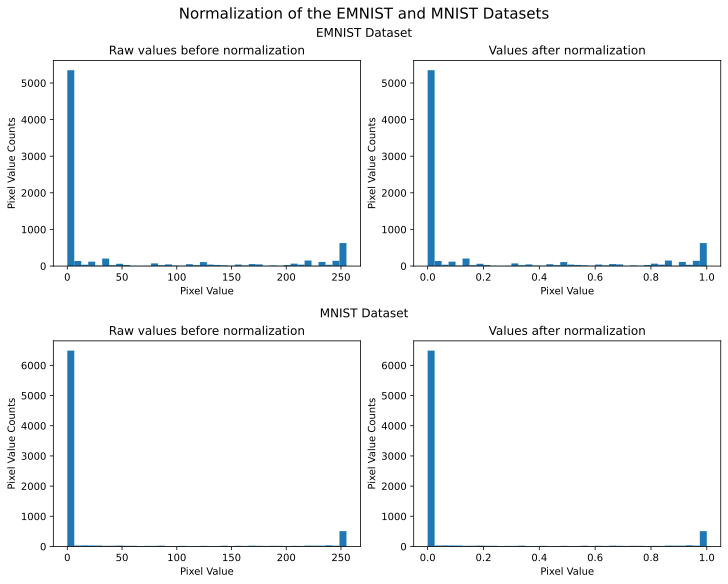

In [ ]:
### Normalize the images and show a before and after plot
fig = plt.figure(constrained_layout=True, figsize=(10,8))
fig.suptitle('Normalization of the EMNIST and MNIST Datasets',fontsize=15)
#fig, ax = plt.subplots(2,2, figsize=(12,8))

subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    if row==0:
      subfig.suptitle(f'EMNIST Dataset')
    else:
      subfig.suptitle(f'MNIST Dataset')


    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
      if (row==0) and (col==0):
        ax.hist(imagesEMNIST[:10,:,:,:].view(1,-1).detach(),40)
        ax.set_title(f'Raw values before normalization')
        ax.set_xlabel('Pixel Value')
        ax.set_ylabel('Pixel Value Counts')

      elif (row==0) and (col==1):
        # normalization
        imagesEMNIST /= torch.max(imagesEMNIST)

        ax.hist(imagesEMNIST[:10,:,:,:].view(1,-1).detach(),40)
        ax.set_title(f'Values after normalization')
        ax.set_xlabel('Pixel Value')
        ax.set_ylabel('Pixel Value Counts')

      elif (row==1) and (col==0):
        ax.hist(imagesMNIST[:10,:,:,:].view(1,-1).detach(),40)
        ax.set_title(f'Raw values before normalization')
        ax.set_xlabel('Pixel Value')
        ax.set_ylabel('Pixel Value Counts')

      elif (row==1) and (col==1):
        # normalization
        imagesMNIST /= torch.max(imagesMNIST)

        ax.hist(imagesMNIST[:10,:,:,:].view(1,-1).detach(),40)
        ax.set_title(f'Values after normalization')
        ax.set_xlabel('Pixel Value')
        ax.set_ylabel('Pixel Value Counts')


plt.show()

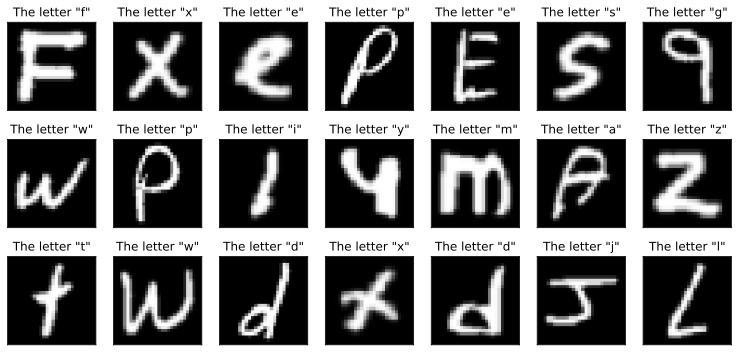

In [ ]:
# visualize some images form the EMNIST dataset
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(imagesEMNIST.shape[0])

  # extract the image and its target letter
  I = np.squeeze( imagesEMNIST[whichpic,:,:] )
  letter = letterCategories[labelsEMNIST[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

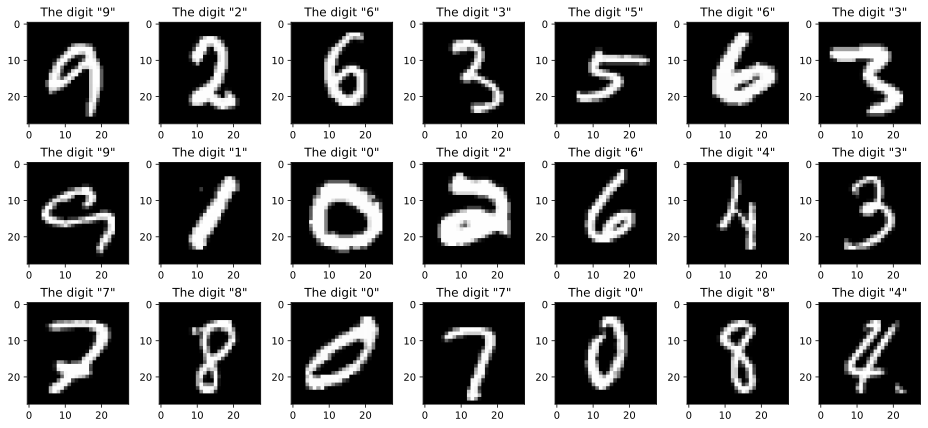

In [ ]:
fig, axs = plt.subplots(3,7, figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pick
  whichpic = np.random.randint(imagesMNIST.shape[0])

  # extract the image and its target digit
  I = np.squeeze(imagesMNIST[whichpic,:,:])
  digit = ddata.classes[labelsMNIST[whichpic]]

  # visualize
  ax.imshow(I, cmap='gray')
  ax.set_title('The digit "%s"'%digit[0])

plt.tight_layout()
plt.show()

# Create train/test groups using DataLoader

In [ ]:
### For the FMNIST dataset

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(imagesEMNIST, labelsEMNIST, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
### For the MNIST dataset

# Step 2: use scikitlearn to split the data
train_data_MNIST, test_data_MNIST, train_labels_MNIST, test_labels_MNIST = train_test_split(imagesMNIST, labelsMNIST, test_size=.1)

# Step 3. convert into PyTorch Datasets
train_data_MNIST = TensorDataset(train_data_MNIST, train_labels_MNIST)
test_data_MNIST = TensorDataset(test_data_MNIST, test_labels_MNIST)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader_MNIST = DataLoader(train_data_MNIST, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader_MNIST = DataLoader(test_data_MNIST, batch_size=test_data_MNIST.tensors[0].shape[0])

In [ ]:
# EMNIST: check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [ ]:
# MNIST: check size (should bei images X channels X width X height
print( train_loader_MNIST.dataset.tensors[0].shape)
print( train_loader_MNIST.dataset.tensors[1].shape)

torch.Size([54000, 1, 28, 28])
torch.Size([54000])


# Create the DL model

In [ ]:
# create a class for the model
def makeTheNet(fc2Units, printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,fc2Units)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer


In [ ]:
# test the model with one batch
fc2Units = 26
net,lossfun,optimizer = makeTheNet(fc2Units, True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 6, 14, 14]
Second CPR block: [32, 6, 7, 7]
Vectorized: [32, 294]
Final output: [32, 26]

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2734, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [ ]:
# a function that trains the model

def function2trainTheModel(net, lossfun,optimizer, train_loader, test_loader,
                           numepochs, freeze):

  # number of epochs
  numepochs = 5

  # # create a new model
  # net,lossfun,optimizer = makeTheNet(fc2Units)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # freeze the output layer if necessary
    if freeze:
      for p in net.named_parameters():
        if 'fc2' not in p[0]:
          p[1].requires_grad = False
        else:
          p[1].requires_grad = True

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

## Step 1: Run the source model and show the results!

In [ ]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)

# set the parameters for the normal EMNIST model
fc2Units=26
numepochs = 5
freeze = False

# create a model instance
net,lossfun,optimizer = makeTheNet(fc2Units, printtoggle=False)

# run the model
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel(net, lossfun,
optimizer,train_loader, test_loader, numepochs, freeze)

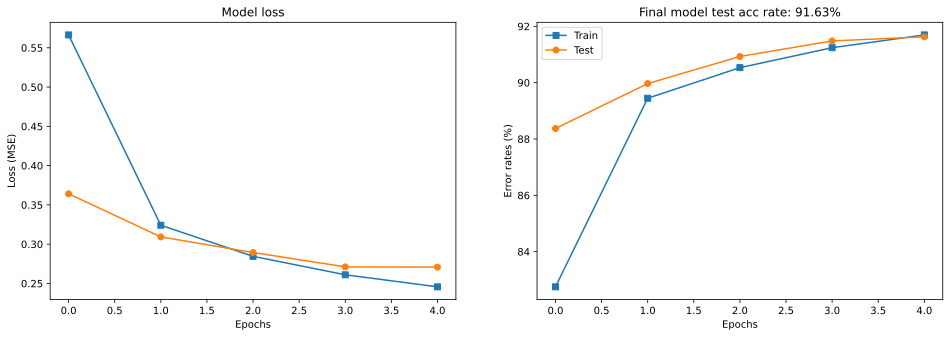

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test acc rate: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Step 2: Test the unchanged source model on the MNIST dataset

In [ ]:
X, y = next(iter(test_loader_MNIST))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# the test
testAccMNIST = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f'MNISTnet performance on MNIST data: {testAccMNIST.item():.2f}%')

MNISTnet performance on MNIST data: 0.50%


## Step 3: Test the modified source model on the MNIST dataset

In [ ]:
# test the modified FMNIST model (twe changed the units in the output layer from 26 to 10) with the MNIST data

# create a new model
fc2Units = 10
numepochs = 1
freeze = False
MNISTnet,lossfun,optimizer = makeTheNet(fc2Units, printtoggle=False)

# train it on numbers data
trainLoss,testLoss,trainAcc,testAcc,MNISTnet = function2trainTheModel(MNISTnet,lossfun,optimizer , train_loader_MNIST, test_loader_MNIST,numepochs, freeze)

print(f'MNISTnet performance on MNIST data: {testAcc[-1:].item():.2f}%')

MNISTnet performance on MNIST data: 98.50%


## Step 4: Create and train the targetNet model



In [ ]:
# create an untrained new model instance of the modified source model, referred to as the targetNet model.
fc2Units= 10
targetNet, lossfun, optimizer = makeTheNet(fc2Units, printtoggle=False)

# send the model to the GPU
targetNet.to(device)

# then replace all the weights in the Target model from the Source model
for target, source in zip(targetNet.named_parameters(),net.named_parameters()):
  target[1].data = copy.deepcopy(source[1].data)

In [ ]:
# check if the gradients were by default computed for all layers
for p in targetNet.named_parameters():
  print(p[0], p[1].requires_grad)

conv1.weight True
conv1.bias True
bnorm1.weight True
bnorm1.bias True
conv2.weight True
conv2.bias True
bnorm2.weight True
bnorm2.bias True
fc1.weight True
fc1.bias True
fc2.weight True
fc2.bias True


In [ ]:
# subject the targetNet to a special kind of training, where we freeze the weights of all layers except the output layer.
freeze = True
numepochs = 5
trainLoss, testLoss, trainAcc, testAcc, targetNet = function2trainTheModel(targetNet, lossfun, optimizer, train_loader_MNIST, test_loader_MNIST,numepochs, freeze)

print(f'MNISTnet performance on MNIST data: {testAcc[-1:].item():.2f}%')

MNISTnet performance on MNIST data: 94.67%


In [ ]:
# check if the gradients were now only computed for the output layer
for p in targetNet.named_parameters():
  print(p[0], p[1].requires_grad)

conv1.weight False
conv1.bias False
bnorm1.weight False
bnorm1.bias False
conv2.weight False
conv2.bias False
bnorm2.weight False
bnorm2.bias False
fc1.weight False
fc1.bias False
fc2.weight True
fc2.bias True


## Visualize a comparison between predicted and ground truth numbers.

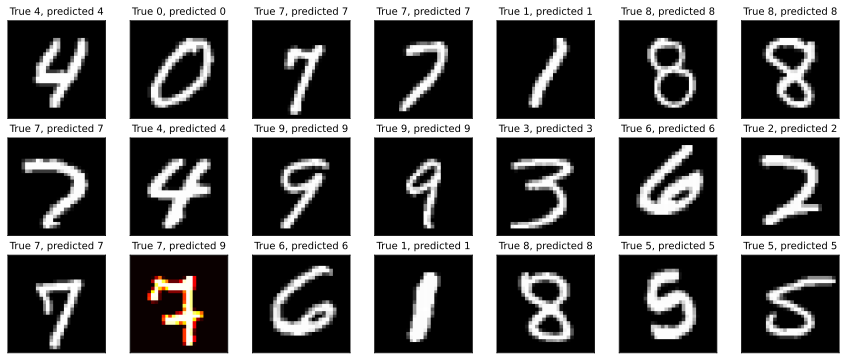

In [ ]:
### visualize some images

digitCategories = []
for label in ddata.classes:
   digitCategories.append((int(label[0])))


# extract X,y from test dataloader
X,y = next(iter(test_loader_MNIST))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = targetNet(X)


# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))


for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueDigit = digitCategories[ y[randex[i]] ]
  predDigit = digitCategories[ torch.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueDigit ==predDigit else 'hot'

  # visualize
  ax.imshow(I,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueDigit,predDigit),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Accuracy by letter

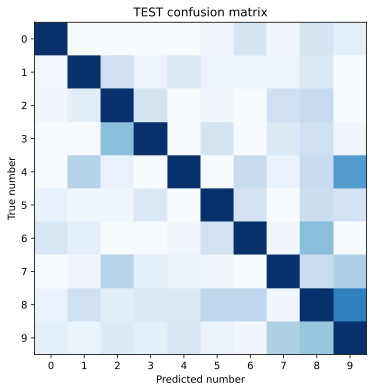

In [ ]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(6,6))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(10),labels=digitCategories)
plt.yticks(range(10),labels=digitCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()

## References:

https://www.udemy.com/course/deeplearning_x